In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import matplotlib.pylab as plt

import chainer
import chainer.links as L
import chainer.functions as F

import varit
import varit.random_variables as rv
from varit.models import vcca

In [3]:
import imp
imp.reload(varit)
imp.reload(rv)
imp.reload(vcca)

<module 'varit.models.vcca' from '../varit/models/vcca.py'>

In [4]:
%matplotlib inline

In [5]:
gpu = 0

# load data

In [6]:
mnist = chainer.datasets.get_mnist()

# define network

In [7]:
class Net1out(chainer.Chain):
    def __init__(self, sensor, hidden, latent, dr=0.1):
        super().__init__(
            l1=L.Linear(sensor, hidden),
            l2=L.Linear(hidden, hidden),
            l3=L.Linear(hidden, hidden),
            m0=L.Linear(hidden, latent),
        )
        self.dr = dr

    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = F.dropout(h, ratio=self.dr)
        h = F.relu(self.l2(h))
        h = F.dropout(h, ratio=self.dr)
        h = F.relu(self.l3(h))
        h = F.dropout(h, ratio=self.dr)
        m0 = self.m0(h)
        return m0

In [8]:
class Net2out(chainer.Chain):
    def __init__(self, sensor, hidden, latent, dr=0.1):
        super().__init__(
            l1=L.Linear(sensor, hidden),
            l2=L.Linear(hidden, hidden),
            l3=L.Linear(hidden, hidden),
            m0=L.Linear(hidden, latent),
            m1=L.Linear(hidden, latent)
        )
        self.dr = dr

    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = F.dropout(h, ratio=self.dr)
        h = F.relu(self.l2(h))
        h = F.dropout(h, ratio=self.dr)
        h = F.relu(self.l3(h))
        h = F.dropout(h, ratio=self.dr)
        m0 = self.m0(h)
        m1 = self.m1(h)
        return m0, m1

# define model

In [9]:
sensor_x = 28 * 28
sensor_y = 10
hidden = 1024
zdim_z = 20
zdim_zx = 40
zdim_zy = 3
dr = 0.1

qzxgx  = rv.ConditionalGaussian(Net2out(sensor_x, hidden, zdim_zx, dr=dr))
qzgx   = rv.ConditionalGaussian(Net2out(sensor_x, hidden, zdim_z, dr=dr))
qzgy   = rv.ConditionalGaussian(Net2out(sensor_y, hidden, zdim_z, dr=dr))
qzygy  = rv.ConditionalGaussian(Net2out(sensor_y, hidden, zdim_zy, dr=dr))
pxgzxz = rv.ConditionalBernoulli(Net1out(zdim_z + zdim_zx, hidden, sensor_x, dr=dr))
pygzyz = rv.ConditionalCategorical(Net1out(zdim_z + zdim_zy, hidden, sensor_y, dr=dr))

model = vcca.VCCA(qzxgx, qzgx, qzgy, qzygy, pxgzxz, pygzyz)

optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [10]:
if 0 <= gpu:
    model.to_gpu(gpu)
    xp = chainer.cuda.cupy
    chainer.cuda.get_device(gpu).use()
else:
    xp = np

In [11]:
n_epoch = 50
batchsize = 100
N = mnist[0].__len__()

sum_loss_log = []

for epoch in range(0, n_epoch):
    print('epoch', epoch)

    perm = np.random.permutation(N)
    
    sum_loss = 0
    for i in range(0, N, batchsize):
        images, labels = mnist[0].__getitem__([perm[i:i + batchsize]])
        x_batch = chainer.Variable(xp.array(images))
        y_batch = chainer.Variable(xp.array(varit.utils.one_hot(labels)))
        loss, _ = model.lower_bound(x_batch, y_batch)
        
        sum_loss += float(loss.data) * batchsize
        model.zerograds()
        loss.backward()
        optimizer.update()
        
    sum_loss_log.append(sum_loss / N)
    print('train mean loss={}'.format(sum_loss / N))

epoch 0
train mean loss=170.87661542256674
epoch 1
train mean loss=135.32653293609619
epoch 2
train mean loss=127.4076435470581
epoch 3
train mean loss=122.99219703674316
epoch 4
train mean loss=120.9914117304484
epoch 5
train mean loss=119.50956109364827
epoch 6
train mean loss=118.68126037597656
epoch 7
train mean loss=117.95392748514811
epoch 8
train mean loss=117.31934079488119
epoch 9
train mean loss=116.73401176452637
epoch 10
train mean loss=116.42922663370769
epoch 11
train mean loss=115.97872266133626
epoch 12
train mean loss=115.66897252400716
epoch 13
train mean loss=115.37638840993246
epoch 14
train mean loss=115.20728583017986
epoch 15
train mean loss=114.9530654144287
epoch 16
train mean loss=114.75314888000489
epoch 17
train mean loss=114.55256548563639
epoch 18
train mean loss=114.26119467417399
epoch 19
train mean loss=114.17954470316569
epoch 20
train mean loss=114.14753976186117
epoch 21
train mean loss=113.93543968200683
epoch 22
train mean loss=113.88623936971028
e

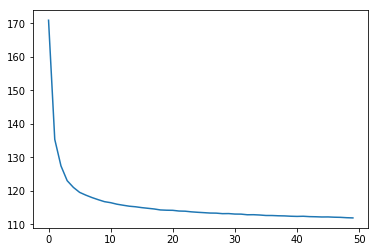

In [12]:
plt.plot(sum_loss_log)

In [13]:
model.to_cpu()
xp = np

In [14]:
model_file_name = 'vcca_mnist'

In [15]:
print('save the model')
chainer.serializers.save_npz(model_file_name + '.model', model)
print('save the optimizer')
chainer.serializers.save_npz(model_file_name + '.state', optimizer)

save the model
save the optimizer


In [16]:
print('load the model')
chainer.serializers.load_npz(model_file_name + '.model', model)
print('load the optimizer')
chainer.serializers.load_npz(model_file_name + '.state', optimizer)

load the model
load the optimizer


In [17]:
train_ind = [np.where(mnist[1].__getitem__(range(100))[1] == i)[0][0] for i in range(10)]
images, labels = mnist[1].__getitem__(train_ind)
x_batch = chainer.Variable(xp.array(images))
y_batch = chainer.Variable(xp.array(varit.utils.one_hot(labels)))
with chainer.no_backprop_mode(), chainer.using_config('train', False):
    px, py = model.reconstract_multiple(x_batch, y_batch)

[0 1 2 3 4 6 6 7 8 9]


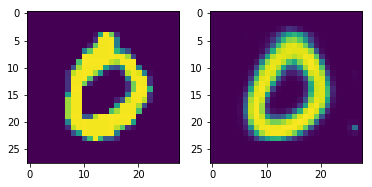

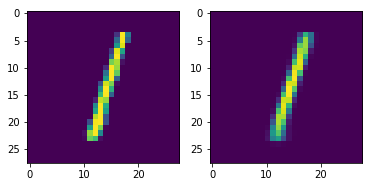

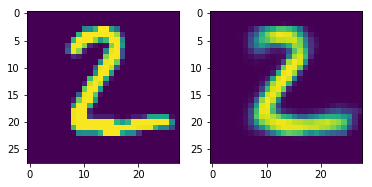

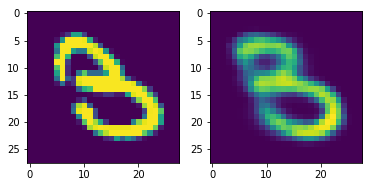

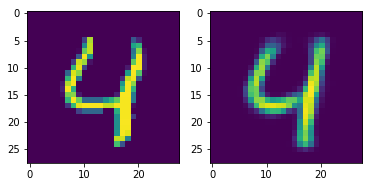

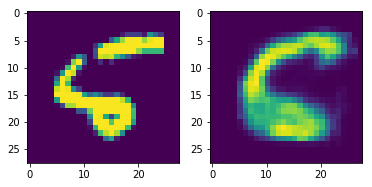

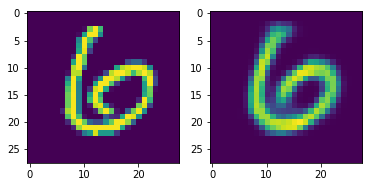

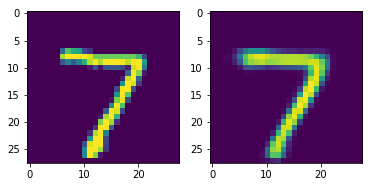

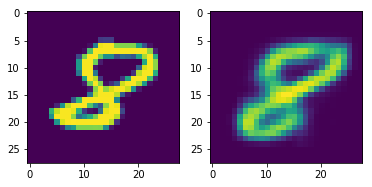

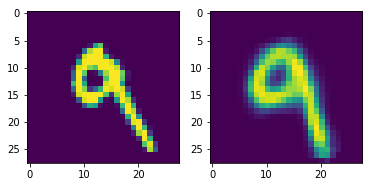

In [18]:
print(np.argmax(py.get_params().data, axis=1))
for i in range(len(px.get_params()[0])):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(images[i].reshape(28, 28))
    plt.subplot(1, 2, 2)
    plt.imshow(px.get_params()[0].data[i].reshape(28, 28))